In [148]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [67]:
df_evadidos = pd.read_csv('./outputs/dropout.csv', index_col=0)
df_formados = pd.read_csv('./outputs/graduated.csv', index_col=0)

In [68]:
df_formados[["Tipo_Escola_Origem", "Reserva vaga"]]

,Tipo_Escola_Origem,Reserva vaga
indice,,
3,E,Ampla Concorrência
26,E,Ampla Concorrência
58,E,Ampla Concorrência
60,E,Ampla Concorrência
62,E,Ampla Concorrência
...,...,...
3293,E,"L2 Esc Publica, Renda<1.5sm, Raca"
3305,P,Não possui
3308,E,Ampla Concorrência


###  Junção dos datasets (Formados e Evadidos)

In [69]:
dataset = pd.concat([df_formados,df_evadidos], axis=0)

In [70]:
dataset.columns.values.tolist()

['Fluxo Escolar - Label',
 'Campus (Nome)',
 'Matrícula retida?',
 'Ingressantes em (Período Letivo)',
 'Modalidade do Curso',
 'Nível de Ensino',
 'Tipo de Modalidade (grupo)',
 'Cidade Aluno',
 'Cód. da Matriz',
 'Cód. do Curso',
 'Data Final Período',
 'Data Início Período',
 'Data Última Alteração Matrícula',
 'Dt Ref Início Matrícula',
 'Dt Ref Início Período Letivo',
 'Estado Aluno',
 'Estrutura Etária',
 'Etnia',
 'Faixa Etária',
 'Forma de Ingresso',
 'Forma de Oferta (grupo)',
 'Ingressantes em  (Ano Letivo)',
 'Num Seq deste Período Letivo',
 'Periodo Letivo (Num)',
 'Previsão de Término (Letivo)',
 'Reserva vaga',
 'Sexo',
 'Tipo de Modalidade',
 'Tipo_Escola_Origem',
 'É matrícula retida neste período letivo?',
 'Última Alteração de Situação',
 'CH',
 'CH. Disc. Obrigatórias',
 'CH. Disc. Optativas',
 'Duracao curso',
 'Idade (Hoje)',
 'Periodos Cursados']

### Formatação de Dados (Romero)

In [71]:
dataset = dataset.drop(columns=["Campus (Nome)"])

#### Conversões p/ binários

In [72]:
dataset["Fluxo Escolar - Label"] = dataset["Fluxo Escolar - Label"].map({'Formados': 0, 'Evadidos': 1})

In [73]:
dataset["Cidade Aluno"] = dataset["Cidade Aluno"].map(lambda cidade: 1 if cidade == 'Acaraú' else 0)

In [74]:
dataset["Sexo"] = dataset["Sexo"].map({'M': 0, 'F': 1})

In [75]:
# dataset["Tipo_Escola_Origem"] = dataset["Tipo_Escola_Origem"].map(lambda cidade: 1 if cidade != 'P' else 0)

In [107]:
dataset["Previsão de Término (Letivo)"] = dataset["Previsão de Término (Letivo)"].map(lambda data: int(data.replace("/","")))

In [113]:
dataset["previsao_ultrapassada"] =  dataset["Previsão de Término (Letivo)"] < dataset["Periodo Letivo (Num)"]

In [ ]:
dataset["previsao_ultrapassada"] = dataset["previsao_ultrapassada"].map({True: 1, False: 0})

##### Dataset Final

In [122]:
dataset_final = dataset[["Fluxo Escolar - Label","Cidade Aluno", "Sexo", "previsao_ultrapassada", 'Nível de Ensino', 'Reserva vaga', 'Etnia', 'Faixa Etária']]

In [123]:
b_encoder = ce.BinaryEncoder(cols=['Nível de Ensino', 'Reserva vaga', 'Etnia', 'Faixa Etária'])

In [127]:
dataset_final = b_encoder.fit_transform(dataset_final)

In [128]:
matriz_correlacao = dataset_final.corr()

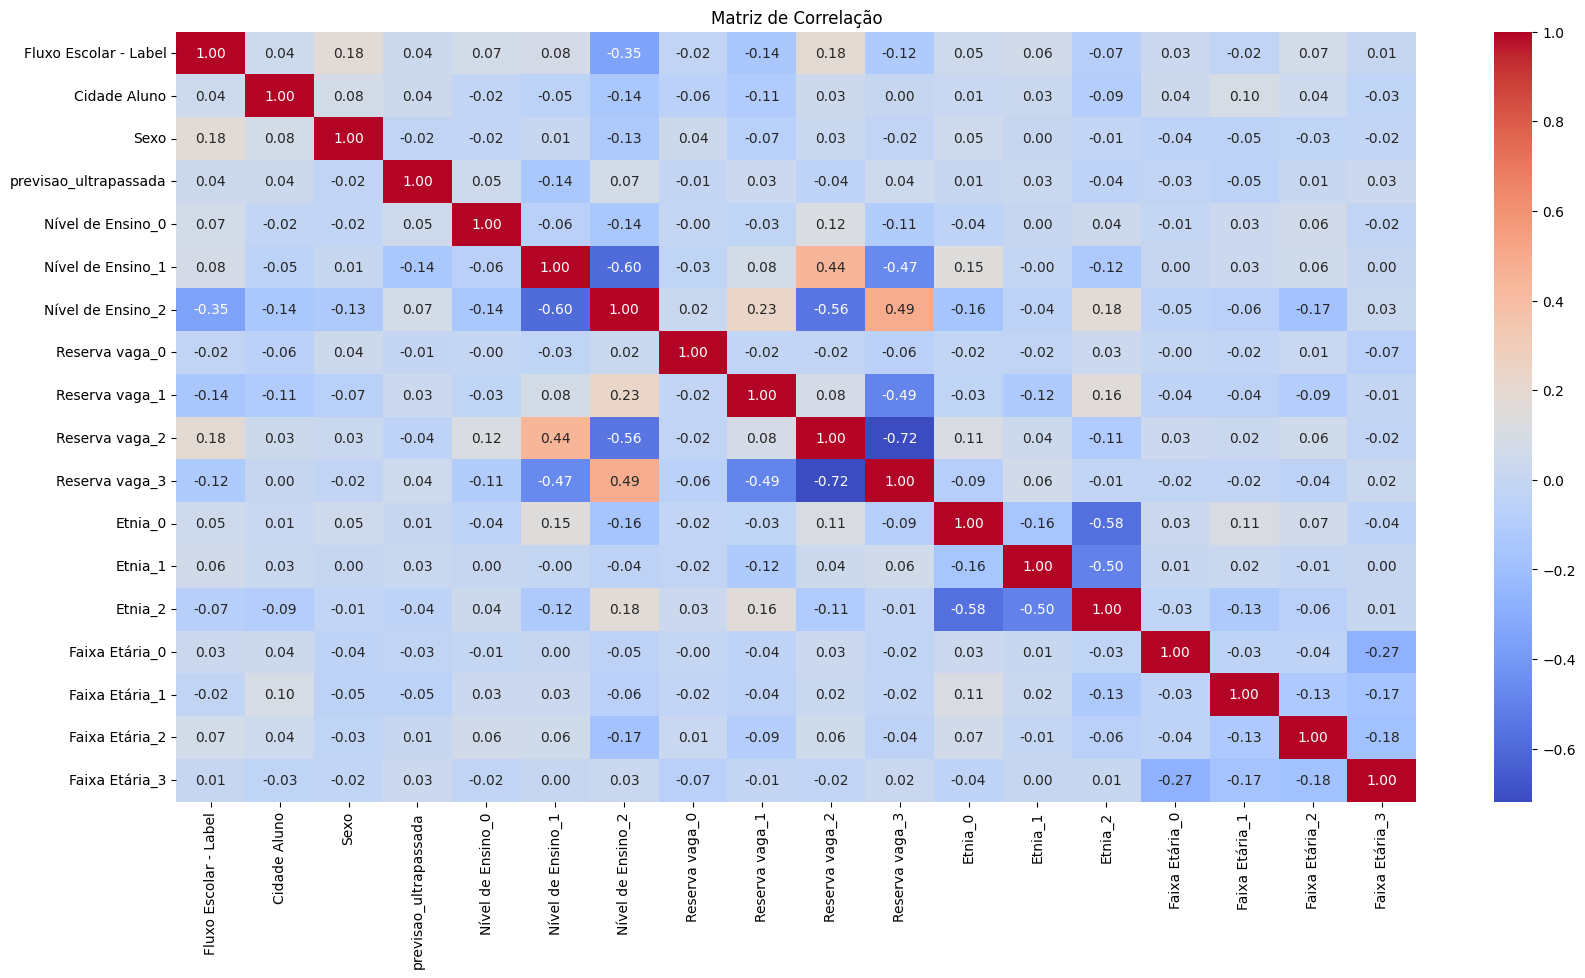

In [130]:
plt.figure(figsize=(20,10))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

### Algoritmo: Random Forest

#### Divisão dos dados

In [134]:
X = dataset_final.drop('Fluxo Escolar - Label', axis=1)
y = dataset_final['Fluxo Escolar - Label']

In [135]:
# Dividir o dataset em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [136]:
# Configurar o modelo Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,          # Número de árvores na floresta
    max_depth=5,               # Profundidade máxima de cada árvore
    min_samples_split=4,       # Número mínimo de amostras necessárias para dividir um nó
    min_samples_leaf=2,        # Número mínimo de amostras que uma folha (nó terminal) deve ter
    class_weight='balanced',   # Ajusta os pesos para lidar com classes desbalanceadas
    random_state=42            # Para reprodutibilidade
)


In [137]:
# Treinar o modelo
rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2,
                       min_samples_split=4, random_state=42)

In [140]:
# Fazer predições no conjunto de teste
y_pred = rf_model.predict(X_test)

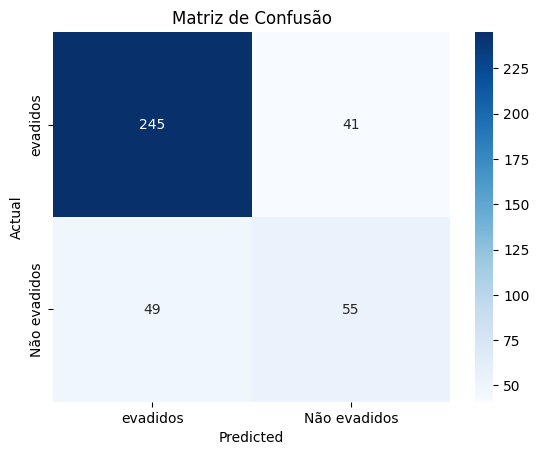

In [155]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['evadidos', 'Não evadidos'], yticklabels=['evadidos','Não evadidos'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusão')
plt.show()

In [154]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

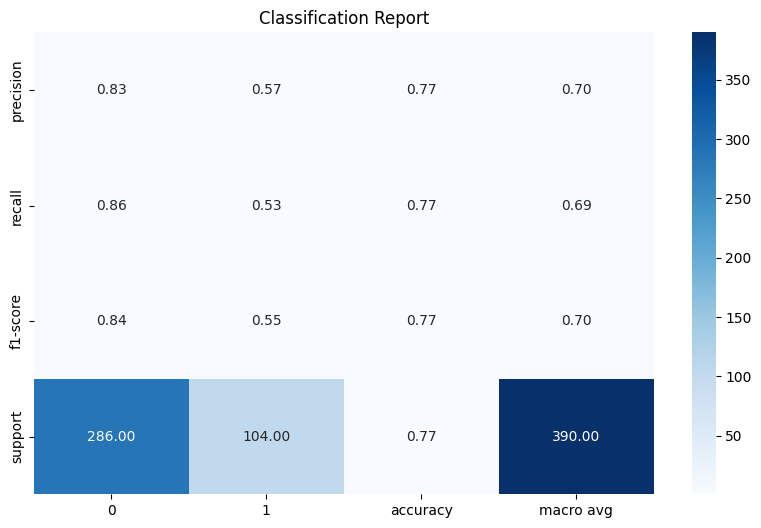

In [146]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_report.iloc[:-1, :].T, annot=True, cmap="Blues", fmt=".2f")

plt.title('Classification Report')
plt.show()



In [149]:
score = accuracy_score(y_test, y_pred)

In [150]:
score

0.7692307692307693

In [151]:
# Extraindo as importâncias das features
feature_importances = rf_model.feature_importances_

# Criando um DataFrame para organizar e visualizar
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Ordenando as features pela importância
features_df = features_df.sort_values(by='Importance', ascending=False)

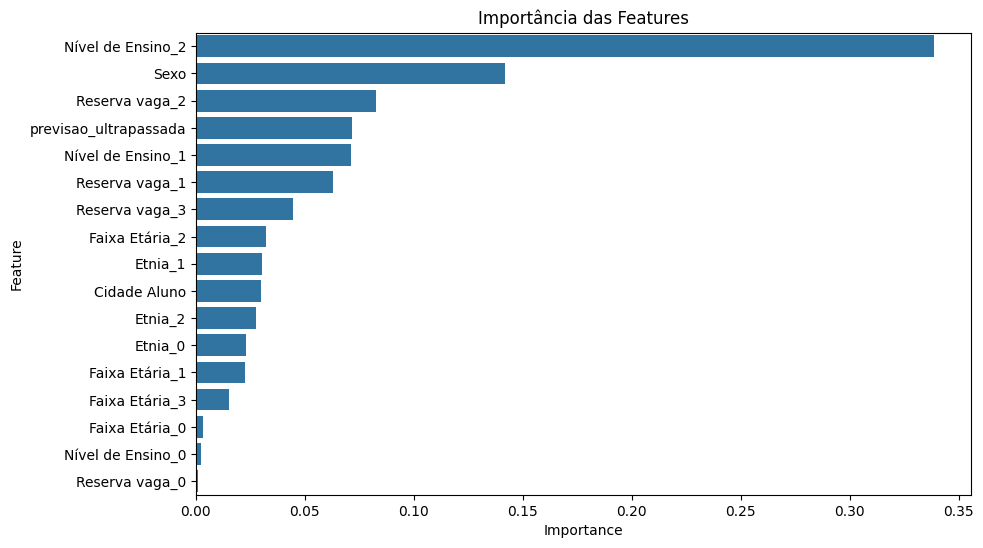

In [152]:
# Plotar as features mais importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df)

plt.title('Importância das Features')
plt.show()


### Functions and encoders to Normalize collumns

In [47]:
# A função para definir o intervalo da carga horária
def put_in_inverval(min: int, max: int, value: int) -> float:
    new_value = (value - min) / (max - min)
    return new_value

## Formatação dos dados (Diego)

In [48]:
# Instância do encoder binário
encoder = ce.BinaryEncoder(cols=['Modalidade do Curso', 'Nível de Ensino', 'Tipo de Modalidade (grupo)', 'Tipo_Escola_Origem', 'Reserva vaga', 'Etnia', 'Estrutura Etária', 'Faixa Etária'])

# Atualmente só pode ser rodado uma vez tem que repensar a lógica;
df_juntos = [df_evadidos, df_formados]

# Para facilitar a implementação normalização dos dados nos datasets divididos ao mesmo tempo eu adicionei em um array
for df in df_juntos: 
    df['Fluxo Escolar - Label'] = df['Fluxo Escolar - Label'].map({
        'Formados': 1,
        'Evadidos': 0
    }).fillna(df['Fluxo Escolar - Label'])

    df['Matrícula retida?'] = df['Matrícula retida?'].map({
        'Dentro do prazo': 1,
        'Fora do prazo': 0
    }).fillna(df['Matrícula retida?'])

    df['É matrícula retida neste período letivo?'] = df['É matrícula retida neste período letivo?'].map({
        'Retida': 1,
        'Não Retida': 0
    }).fillna(df['É matrícula retida neste período letivo?']) 
    
    df['Ingressantes em (Período Letivo)'] = df['Ingressantes em (Período Letivo)'].map(lambda date: 0 if str(date)[-1] == '1' else 1)
    
    df['CH. Disc. Obrigatórias'] = df['CH. Disc. Obrigatórias'].map(lambda carga_horaria_obg: put_in_inverval(min=60, max=3260, value=carga_horaria_obg))
    
    df['Cidade Aluno'] = df['Cidade Aluno'].map(lambda cidade: 1 if cidade == 'Acaraú' else 0)
    
    df['Sexo'] =  df['Sexo'].map({'M': 1, 'F': 0})
    
# Colocar o algoritmo de binarização nos dataframes
df_evadidos = encoder.fit_transform(df_evadidos)
df_formados = encoder.fit_transform(df_formados)

In [49]:
df_evadidos

,Fluxo Escolar - Label,Campus (Nome),Matrícula retida?,Ingressantes em (Período Letivo),Modalidade do Curso_0,Modalidade do Curso_1,Modalidade do Curso_2,Nível de Ensino_0,Nível de Ensino_1,Nível de Ensino_2,...,Tipo_Escola_Origem_1,Tipo_Escola_Origem_2,É matrícula retida neste período letivo?,Última Alteração de Situação,CH,CH. Disc. Obrigatórias,CH. Disc. Optativas,Duracao curso,Idade (Hoje),Periodos Cursados
indice,,,,,,,,,,,,,,,,,,,,,
1,0,Acaraú,1,0,0,0,1,0,0,1,...,0,1,0,2016-02-26,1240,0.36875,0,4,28,2
4,0,Acaraú,1,1,0,1,0,0,1,0,...,1,0,0,2016-12-01,2940,0.87500,80,8,23,2
12,0,Acaraú,1,1,0,1,0,0,1,0,...,0,1,0,2018-12-27,2960,0.90625,0,8,35,7
21,0,Acaraú,1,0,0,1,1,0,1,1,...,0,1,0,2016-07-11,160,0.03125,0,2,33,1
23,0,Acaraú,1,1,0,1,1,0,1,1,...,0,1,0,2018-11-20,160,0.03125,0,2,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3301,0,Acaraú,1,0,0,0,1,0,0,1,...,0,1,0,2015-12-29,1480,0.44375,0,4,23,1
3302,0,Acaraú,1,0,0,0,1,0,0,1,...,0,1,0,2019-12-04,1480,0.44375,0,4,23,2
3310,0,Acaraú,1,0,0,0,1,0,0,1,...,0,1,0,2016-06-06,1240,0.36875,0,4,28,2


In [50]:
df_formados

,Fluxo Escolar - Label,Campus (Nome),Matrícula retida?,Ingressantes em (Período Letivo),Modalidade do Curso_0,Modalidade do Curso_1,Modalidade do Curso_2,Nível de Ensino_0,Nível de Ensino_1,Nível de Ensino_2,...,Tipo_Escola_Origem_1,Tipo_Escola_Origem_2,É matrícula retida neste período letivo?,Última Alteração de Situação,CH,CH. Disc. Obrigatórias,CH. Disc. Optativas,Duracao curso,Idade (Hoje),Periodos Cursados
indice,,,,,,,,,,,,,,,,,,,,,
3,1,Acaraú,0,1,0,0,1,0,0,1,...,0,1,0,2018-11-09,800,0.23125,0,2,23,2
26,1,Acaraú,1,0,0,0,1,0,0,1,...,0,1,0,2018-05-16,800,0.23125,0,2,21,2
58,1,Acaraú,1,0,0,0,1,0,0,1,...,0,1,0,2018-05-16,800,0.23125,0,2,21,2
60,1,Acaraú,1,0,0,0,1,0,0,1,...,0,1,0,2019-05-09,800,0.23125,0,2,35,2
62,1,Acaraú,1,0,0,0,1,0,0,1,...,0,1,0,2017-04-19,800,0.23125,0,2,26,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3293,1,Acaraú,0,0,0,0,1,0,0,1,...,0,1,1,2018-12-28,1240,0.36875,0,4,24,8
3305,1,Acaraú,0,1,0,1,0,0,1,0,...,1,0,1,2019-10-18,160,0.03125,0,2,40,2
3308,1,Acaraú,0,1,0,0,1,0,0,1,...,0,1,0,2018-11-09,800,0.23125,0,2,31,2


In [52]:
df_original = pd.concat([df_formados,df_evadidos], axis=0)
df_original = df_original[['Matrícula retida?', 'Ingressantes em (Período Letivo)', 
    'Modalidade do Curso_0', 'Modalidade do Curso_1', 'Modalidade do Curso_2', 
    'Nível de Ensino_0', 'Nível de Ensino_1', 'Nível de Ensino_2',
    'Tipo de Modalidade (grupo)_0', 'Tipo de Modalidade (grupo)_1',
    'CH. Disc. Obrigatórias', 'Cidade Aluno', 
    'Tipo_Escola_Origem_0', 'Tipo_Escola_Origem_1', 'Tipo_Escola_Origem_2', 
    'Reserva vaga_0', 'Reserva vaga_1', 'Reserva vaga_2',
    'Estrutura Etária_0', 'Estrutura Etária_1', 
    'Etnia_0', 'Etnia_1', 'Etnia_2', 
    'Faixa Etária_0', 'Faixa Etária_1', 'Faixa Etária_2', 'Faixa Etária_3',
    'Sexo']]

In [53]:
df_original

,Matrícula retida?,Ingressantes em (Período Letivo),Modalidade do Curso_0,Modalidade do Curso_1,Modalidade do Curso_2,Nível de Ensino_0,Nível de Ensino_1,Nível de Ensino_2,Tipo de Modalidade (grupo)_0,Tipo de Modalidade (grupo)_1,...,Estrutura Etária_0,Estrutura Etária_1,Etnia_0,Etnia_1,Etnia_2,Faixa Etária_0,Faixa Etária_1,Faixa Etária_2,Faixa Etária_3,Sexo
indice,,,,,,,,,,,,,,,,,,,,,
3,0,1,0,0,1,0,0,1,0,1,...,0,1,0,0,1,0,0,0,1,1
26,1,0,0,0,1,0,0,1,0,1,...,0,1,0,1,0,0,0,0,1,0
58,1,0,0,0,1,0,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0
60,1,0,0,0,1,0,0,1,0,1,...,0,1,0,1,1,0,0,1,0,0
62,1,0,0,0,1,0,0,1,0,1,...,0,1,0,1,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3301,1,0,0,0,1,0,0,1,0,1,...,0,1,0,1,0,0,0,1,0,1
3302,1,0,0,0,1,0,0,1,0,1,...,0,1,0,1,0,0,0,1,0,1
3310,1,0,0,0,1,0,0,1,0,1,...,0,1,1,1,0,0,0,0,1,0


In [54]:
correlation_matrix = df_original.corr()
correlation_matrix

,Matrícula retida?,Ingressantes em (Período Letivo),Modalidade do Curso_0,Modalidade do Curso_1,Modalidade do Curso_2,Nível de Ensino_0,Nível de Ensino_1,Nível de Ensino_2,Tipo de Modalidade (grupo)_0,Tipo de Modalidade (grupo)_1,...,Estrutura Etária_0,Estrutura Etária_1,Etnia_0,Etnia_1,Etnia_2,Faixa Etária_0,Faixa Etária_1,Faixa Etária_2,Faixa Etária_3,Sexo
Matrícula retida?,1.000000,-0.248506,-0.049101,0.180064,-0.251164,-0.049101,0.180064,-0.251164,0.172489,-0.172489,...,0.063086,-0.063086,0.024883,0.126026,-0.121463,0.014580,0.010485,0.091604,-0.168060,0.069681
Ingressantes em (Período Letivo),-0.248506,1.000000,0.062336,0.032804,-0.047342,0.062336,0.032804,-0.047342,0.041976,-0.041976,...,-0.003988,0.003988,-0.046691,0.002527,0.051196,0.011197,0.031407,-0.018996,0.062818,-0.036306
Modalidade do Curso_0,-0.049101,0.062336,1.000000,-0.062612,-0.107258,1.000000,-0.062612,-0.107258,0.085516,-0.085516,...,-0.010511,0.010511,-0.028252,-0.062192,0.089804,-0.006478,0.030665,0.001694,0.034735,0.017145
Modalidade do Curso_1,0.180064,0.032804,-0.062612,1.000000,-0.782751,-0.062612,1.000000,-0.782751,0.989028,-0.989028,...,-0.054772,0.054772,0.093440,0.012429,-0.033298,0.032110,0.023034,0.022732,0.036691,-0.011392
Modalidade do Curso_2,-0.251164,-0.047342,-0.107258,-0.782751,1.000000,-0.107258,-0.782751,1.000000,-0.797294,0.797294,...,0.027327,-0.027327,-0.027945,0.024321,-0.024292,-0.033974,-0.011569,-0.076540,-0.022976,-0.031656
Nível de Ensino_0,-0.049101,0.062336,1.000000,-0.062612,-0.107258,1.000000,-0.062612,-0.107258,0.085516,-0.085516,...,-0.010511,0.010511,-0.028252,-0.062192,0.089804,-0.006478,0.030665,0.001694,0.034735,0.017145
Nível de Ensino_1,0.180064,0.032804,-0.062612,1.000000,-0.782751,-0.062612,1.000000,-0.782751,0.989028,-0.989028,...,-0.054772,0.054772,0.093440,0.012429,-0.033298,0.032110,0.023034,0.022732,0.036691,-0.011392
Nível de Ensino_2,-0.251164,-0.047342,-0.107258,-0.782751,1.000000,-0.107258,-0.782751,1.000000,-0.797294,0.797294,...,0.027327,-0.027327,-0.027945,0.024321,-0.024292,-0.033974,-0.011569,-0.076540,-0.022976,-0.031656
Tipo de Modalidade (grupo)_0,0.172489,0.041976,0.085516,0.989028,-0.797294,0.085516,0.989028,-0.797294,1.000000,-1.000000,...,-0.056234,0.056234,0.089099,0.003202,-0.019948,0.031096,0.027534,0.022944,0.041770,-0.008834
Tipo de Modalidade (grupo)_1,-0.172489,-0.041976,-0.085516,-0.989028,0.797294,-0.085516,-0.989028,0.797294,-1.000000,1.000000,...,0.056234,-0.056234,-0.089099,-0.003202,0.019948,-0.031096,-0.027534,-0.022944,-0.041770,0.008834


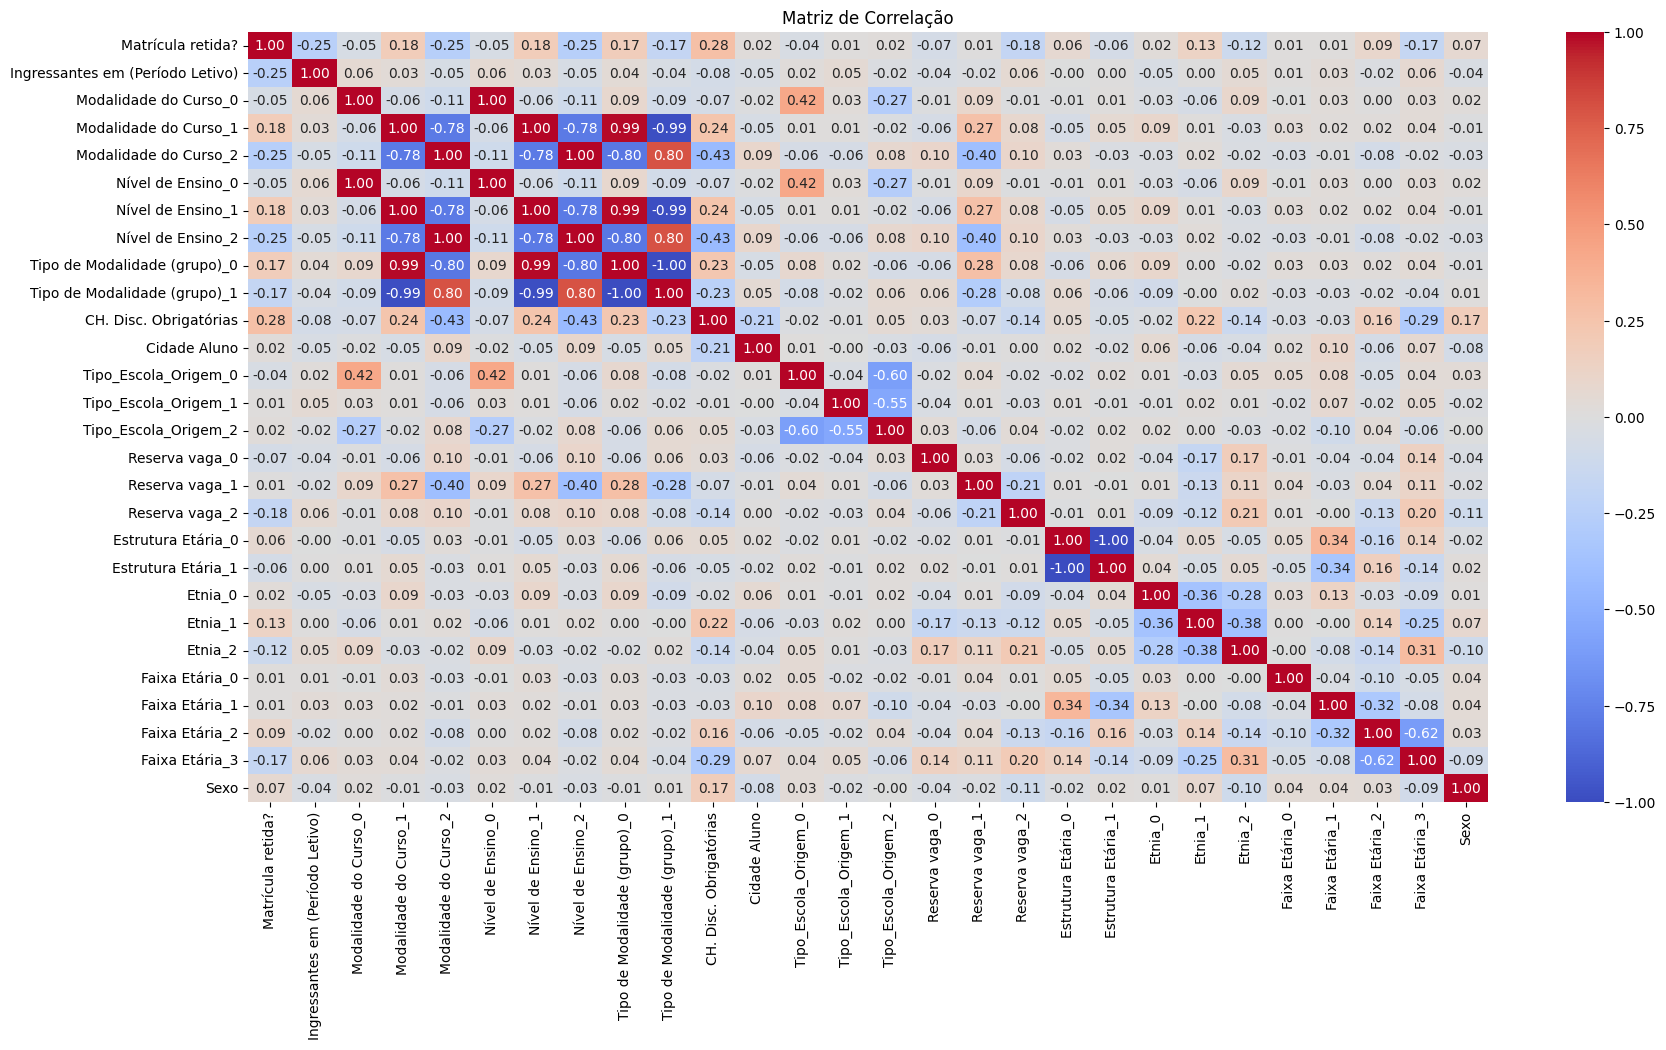

In [60]:
plt.figure(figsize=(20,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

### Dividing in tests

In [9]:
formados_x_treino, formados_x_teste, formados_y_treino, formados_y_teste = train_test_split(df_formados.drop('Fluxo Escolar - Label', axis=1), df_formados['Fluxo Escolar - Label'], test_size=0.2, random_state=2)


In [10]:
formados_x_treino

,Campus (Nome),Matrícula retida?,Ingressantes em (Período Letivo),Modalidade do Curso_0,Modalidade do Curso_1,Modalidade do Curso_2,Nível de Ensino_0,Nível de Ensino_1,Nível de Ensino_2,Tipo de Modalidade (grupo)_0,...,Tipo_Escola_Origem_1,Tipo_Escola_Origem_2,É matrícula retida neste período letivo?,Última Alteração de Situação,CH,CH. Disc. Obrigatórias,CH. Disc. Optativas,Duracao curso,Idade (Hoje),Periodos Cursados
indice,,,,,,,,,,,,,,,,,,,,,
130,Acaraú,0,0,0,0,1,0,0,1,0,...,0,1,1,2019-05-09,1480,0.44375,0,4,23,6
2096,Acaraú,1,0,0,1,0,0,1,0,1,...,0,1,0,2019-05-09,160,0.03125,0,2,20,2
3125,Acaraú,1,1,0,1,0,0,1,0,1,...,0,1,0,2016-05-27,160,0.03125,0,2,24,1
961,Acaraú,1,0,0,1,0,0,1,0,1,...,0,1,0,2016-10-18,160,0.03125,0,2,28,1
2317,Acaraú,0,0,0,0,1,0,0,1,0,...,0,1,0,2018-11-09,800,0.23125,0,2,24,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,Acaraú,0,1,0,0,1,0,0,1,0,...,0,1,0,2019-10-18,1080,0.31875,0,4,24,4
250,Acaraú,0,1,0,0,1,0,0,1,0,...,0,1,0,2019-10-18,800,0.23125,0,2,22,2
715,Acaraú,0,0,0,0,1,0,0,1,0,...,0,1,1,2017-11-01,800,0.23125,0,2,23,3


In [11]:
formados_y_treino

indice
130     1
2096    1
3125    1
961     1
2317    1
       ..
2917    1
250     1
715     1
185     1
1712    1
Name: Fluxo Escolar - Label, Length: 280, dtype: int64

In [12]:
evadidos_x_treino, evadidos_x_teste, evadidos_y_treino, evadidos_y_teste = train_test_split(df_evadidos.drop('Fluxo Escolar - Label', axis=1), df_evadidos['Fluxo Escolar - Label'], test_size=0.2, random_state=2)


In [13]:
evadidos_x_treino

,Campus (Nome),Matrícula retida?,Ingressantes em (Período Letivo),Modalidade do Curso_0,Modalidade do Curso_1,Modalidade do Curso_2,Nível de Ensino_0,Nível de Ensino_1,Nível de Ensino_2,Tipo de Modalidade (grupo)_0,...,Tipo_Escola_Origem_1,Tipo_Escola_Origem_2,É matrícula retida neste período letivo?,Última Alteração de Situação,CH,CH. Disc. Obrigatórias,CH. Disc. Optativas,Duracao curso,Idade (Hoje),Periodos Cursados
indice,,,,,,,,,,,,,,,,,,,,,
2703,Acaraú,0,1,0,0,1,0,0,1,0,...,0,1,1,2018-12-27,1080,0.31875,0,4,23,7
2495,Acaraú,0,1,0,1,0,0,1,0,1,...,0,1,1,2019-12-04,3200,0.98125,0,8,23,9
2261,Acaraú,1,1,0,1,0,0,1,0,1,...,0,1,0,2017-08-04,2960,0.90625,0,8,29,2
1780,Acaraú,1,0,0,0,1,0,0,1,0,...,0,1,0,2018-11-08,1240,0.36875,0,4,24,1
2239,Acaraú,1,1,0,0,1,0,0,1,0,...,0,1,0,2019-06-14,1240,0.36875,0,4,27,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1889,Acaraú,1,0,0,0,1,0,0,1,0,...,0,1,0,2018-12-27,800,0.23125,0,2,22,2
2070,Acaraú,1,1,0,0,1,0,0,1,0,...,0,1,0,2017-12-29,1480,0.44375,0,4,28,3
1727,Acaraú,0,1,0,0,1,0,0,1,0,...,0,1,1,2018-12-27,800,0.23125,0,2,25,3


In [14]:
evadidos_y_treino

indice
2703    0
2495    0
2261    0
1780    0
2239    0
       ..
1889    0
2070    0
1727    0
1861    0
623     0
Name: Fluxo Escolar - Label, Length: 760, dtype: int64

In [15]:
x_treino = pd.concat([formados_x_treino, evadidos_x_treino])

In [16]:
x_teste = pd.concat([formados_x_teste, evadidos_x_teste])

In [17]:
y_treino = pd.concat([formados_y_treino, evadidos_y_treino])

In [18]:
y_teste = pd.concat([formados_y_teste, evadidos_y_teste])

In [19]:
x_treino

,Campus (Nome),Matrícula retida?,Ingressantes em (Período Letivo),Modalidade do Curso_0,Modalidade do Curso_1,Modalidade do Curso_2,Nível de Ensino_0,Nível de Ensino_1,Nível de Ensino_2,Tipo de Modalidade (grupo)_0,...,Tipo_Escola_Origem_2,É matrícula retida neste período letivo?,Última Alteração de Situação,CH,CH. Disc. Obrigatórias,CH. Disc. Optativas,Duracao curso,Idade (Hoje),Periodos Cursados,Reserva vaga_3
indice,,,,,,,,,,,,,,,,,,,,,
130,Acaraú,0,0,0,0,1,0,0,1,0,...,1,1,2019-05-09,1480,0.44375,0,4,23,6,NaN
2096,Acaraú,1,0,0,1,0,0,1,0,1,...,1,0,2019-05-09,160,0.03125,0,2,20,2,NaN
3125,Acaraú,1,1,0,1,0,0,1,0,1,...,1,0,2016-05-27,160,0.03125,0,2,24,1,NaN
961,Acaraú,1,0,0,1,0,0,1,0,1,...,1,0,2016-10-18,160,0.03125,0,2,28,1,NaN
2317,Acaraú,0,0,0,0,1,0,0,1,0,...,1,0,2018-11-09,800,0.23125,0,2,24,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1889,Acaraú,1,0,0,0,1,0,0,1,0,...,1,0,2018-12-27,800,0.23125,0,2,22,2,1.0
2070,Acaraú,1,1,0,0,1,0,0,1,0,...,1,0,2017-12-29,1480,0.44375,0,4,28,3,0.0
1727,Acaraú,0,1,0,0,1,0,0,1,0,...,1,1,2018-12-27,800,0.23125,0,2,25,3,1.0


In [20]:
x_teste

,Campus (Nome),Matrícula retida?,Ingressantes em (Período Letivo),Modalidade do Curso_0,Modalidade do Curso_1,Modalidade do Curso_2,Nível de Ensino_0,Nível de Ensino_1,Nível de Ensino_2,Tipo de Modalidade (grupo)_0,...,Tipo_Escola_Origem_2,É matrícula retida neste período letivo?,Última Alteração de Situação,CH,CH. Disc. Obrigatórias,CH. Disc. Optativas,Duracao curso,Idade (Hoje),Periodos Cursados,Reserva vaga_3
indice,,,,,,,,,,,,,,,,,,,,,
257,Acaraú,0,1,0,1,0,0,1,0,1,...,1,0,2019-10-18,160,0.03125,0,2,24,2,NaN
2356,Acaraú,1,0,0,1,1,0,1,1,1,...,1,0,2019-06-05,3260,1.00000,0,8,25,8,NaN
2632,Acaraú,1,0,0,1,0,0,1,0,1,...,1,0,2016-10-18,160,0.03125,0,2,22,1,NaN
2620,Acaraú,1,1,0,1,0,0,1,0,1,...,1,0,2016-05-27,160,0.03125,0,2,31,1,NaN
2279,Acaraú,1,0,0,1,0,0,1,0,1,...,0,0,2016-10-18,160,0.03125,0,2,30,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,Acaraú,1,1,0,1,0,0,1,0,1,...,1,0,2019-06-06,2960,0.90625,0,8,24,7,1.0
3268,Acaraú,1,1,0,1,0,0,1,0,1,...,1,0,2016-06-06,2960,0.90625,0,8,25,1,1.0
81,Acaraú,0,1,0,1,1,0,1,1,1,...,1,1,2017-06-22,160,0.03125,0,2,28,2,1.0


In [21]:
y_treino

indice
130     1
2096    1
3125    1
961     1
2317    1
       ..
1889    0
2070    0
1727    0
1861    0
623     0
Name: Fluxo Escolar - Label, Length: 1040, dtype: int64

In [22]:
y_teste

indice
257     1
2356    1
2632    1
2620    1
2279    1
       ..
2496    0
3268    0
81      0
2156    0
687     0
Name: Fluxo Escolar - Label, Length: 260, dtype: int64

### Implementing Kneighbors Classifier

In [23]:
# Import classfier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

# Seleção das colunas do x treino e teste que serão utilizadas no algoritmo

x_treino_dados_formatados = x_treino[[
    'Matrícula retida?', 'Ingressantes em (Período Letivo)', 
    'Modalidade do Curso_0', 'Modalidade do Curso_1', 'Modalidade do Curso_2', 
    'Nível de Ensino_0', 'Nível de Ensino_1', 'Nível de Ensino_2',
    'Tipo de Modalidade (grupo)_0', 'Tipo de Modalidade (grupo)_1',
    'CH. Disc. Obrigatórias', 'Cidade Aluno', 
    'Tipo_Escola_Origem_0', 'Tipo_Escola_Origem_1', 'Tipo_Escola_Origem_2', 
    'Reserva vaga_0', 'Reserva vaga_1', 'Reserva vaga_2',
    'Estrutura Etária_0', 'Estrutura Etária_1', 
    'Etnia_0', 'Etnia_1', 'Etnia_2', 
    'Faixa Etária_0', 'Faixa Etária_1', 'Faixa Etária_2', 'Faixa Etária_3',
    'Sexo'
]]

x_teste_dados_formatados =  x_teste[[
    'Matrícula retida?', 'Ingressantes em (Período Letivo)', 
    'Modalidade do Curso_0', 'Modalidade do Curso_1', 'Modalidade do Curso_2', 
    'Nível de Ensino_0', 'Nível de Ensino_1', 'Nível de Ensino_2',
    'Tipo de Modalidade (grupo)_0', 'Tipo de Modalidade (grupo)_1',
    'CH. Disc. Obrigatórias', 'Cidade Aluno', 
    'Tipo_Escola_Origem_0', 'Tipo_Escola_Origem_1', 'Tipo_Escola_Origem_2', 
    'Reserva vaga_0', 'Reserva vaga_1', 'Reserva vaga_2',
    'Estrutura Etária_0', 'Estrutura Etária_1', 
    'Etnia_0', 'Etnia_1', 'Etnia_2', 
    'Faixa Etária_0', 'Faixa Etária_1', 'Faixa Etária_2', 'Faixa Etária_3',
    'Sexo'
]]

# NeighborsClassifier and SGDClassifier instancias
kn_class
kn_class = KNeighborsClassifier(n_neighbors=3, weights="distance")
sgd_class = SGDClassifier(alpha=0.001,loss='hinge',max_iter=100,tol=0.001,n_jobs=-1,early_stopping=True,n_iter_no_change=2)

clf.fit(
    x_treino_dados_formatados, y_treino
)

sgd_class.fit(x_treino_dados_formatados,y_treino)

predictions_kn = kn_class.predict(x_teste_dados_formatados)
predictions_sgd = sgd_class.predict(x_teste_dados_formatados)



In [24]:
# See the model accuracy
from sklearn.metrics import accuracy_score

score = accuracy_score(y_teste, predictions_kn)

print(f"Test Accuracy: {score}")
# Output - Test Accuracy : 0.97

Test Accuracy: 0.95


In [25]:
acc = accuracy_score(y_teste,predictions_sgd)
print(acc)

0.9230769230769231


In [26]:
cm = confusion_matrix(y_teste, predictions_kn)

In [37]:
cm

array([[182,   8],
       [  5,  65]])

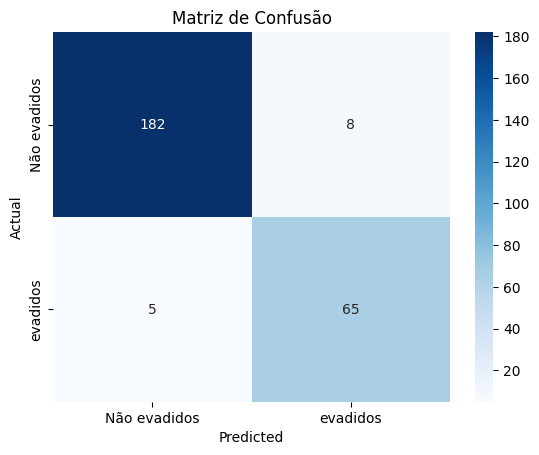

In [42]:
# Plotando a matriz de confusão
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não evadidos', 'evadidos'], yticklabels=['Não evadidos', 'evadidos'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusão')
plt.show()


### Matriz de Correlação

In [44]:
df_original

,Fluxo Escolar - Label,Campus (Nome),Matrícula retida?,Ingressantes em (Período Letivo),Modalidade do Curso,Nível de Ensino,Tipo de Modalidade (grupo),Cidade Aluno,Cód. da Matriz,Cód. do Curso,...,Tipo de Modalidade,Tipo_Escola_Origem,É matrícula retida neste período letivo?,Última Alteração de Situação,CH,CH. Disc. Obrigatórias,CH. Disc. Optativas,Duracao curso,Idade (Hoje),Periodos Cursados
indice,,,,,,,,,,,,,,,,,,,,,
3,Formados,Acaraú,Fora do prazo,20172,Subsequente,Técnico,Educação Profissional,Marco,7083,11204,...,Educação Profissional,E,Não Retida,2018-11-09,800,800,0,2,23,2
26,Formados,Acaraú,Dentro do prazo,20171,Subsequente,Técnico,Educação Profissional,Acaraú,7083,11204,...,Educação Profissional,E,Não Retida,2018-05-16,800,800,0,2,21,2
58,Formados,Acaraú,Dentro do prazo,20171,Subsequente,Técnico,Educação Profissional,Acaraú,7083,11204,...,Educação Profissional,E,Não Retida,2018-05-16,800,800,0,2,21,2
60,Formados,Acaraú,Dentro do prazo,20181,Subsequente,Técnico,Educação Profissional,Acaraú,5929,11203,...,Educação Profissional,E,Não Retida,2019-05-09,800,800,0,2,35,2
62,Formados,Acaraú,Dentro do prazo,20161,Subsequente,Técnico,Educação Profissional,Acaraú,5929,11203,...,Educação Profissional,E,Não Retida,2017-04-19,800,800,0,2,26,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3301,Evadidos,Acaraú,Dentro do prazo,20151,Subsequente,Técnico,Educação Profissional,Acaraú,4928,11202,...,Educação Profissional,E,Não Retida,2015-12-29,1480,1480,0,4,23,1
3302,Evadidos,Acaraú,Dentro do prazo,20191,Subsequente,Técnico,Educação Profissional,Acaraú,4928,11202,...,Educação Profissional,E,Não Retida,2019-12-04,1480,1480,0,4,23,2
3310,Evadidos,Acaraú,Dentro do prazo,20151,Subsequente,Técnico,Educação Profissional,Itarema,5158,11200,...,Educação Profissional,E,Não Retida,2016-06-06,1240,1240,0,4,28,2
